In [1]:
import numpy as np
from matplotlib import cm as colormap
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from ipywidgets import widgets
from IPython.display import display
from io import BytesIO

In [2]:
BASE_DIR = 'D:/Kuliah/Skripsi/plant-images-dataset-600'
print(f"list directory: {sorted(os.listdir(BASE_DIR))}")

TRAIN_DIR = os.path.join(BASE_DIR, 'train')
print(f"train directory: {sorted(os.listdir(TRAIN_DIR))}")

TEST_DIR = os.path.join(BASE_DIR, 'test')
print(f"test directory: {sorted(os.listdir(TEST_DIR))}")

VAL_DIR = os.path.join(BASE_DIR, 'val')
print(f"validation directory: {sorted(os.listdir(VAL_DIR))}")

list directory: ['test', 'train', 'val']
train directory: ['Bayam', 'Jagung', 'Jambu Air', 'Jambu Biji', 'Jeruk', 'Kacang Panjang', 'Kangkung', 'Kelapa', 'Kentang', 'Kubis', 'Mangga', 'Melon', 'Mentimun', 'Nanas', 'Pepaya', 'Pisang', 'Semangka', 'Singkong', 'Terung', 'Tomat', 'Ubi Ungu', 'Wortel']
test directory: ['Bayam', 'Jagung', 'Jambu Air', 'Jambu Biji', 'Jeruk', 'Kacang Panjang', 'Kangkung', 'Kelapa', 'Kentang', 'Kubis', 'Mangga', 'Melon', 'Mentimun', 'Nanas', 'Pepaya', 'Pisang', 'Semangka', 'Singkong', 'Terung', 'Tomat', 'Ubi Ungu', 'Wortel']
validation directory: ['Bayam', 'Jagung', 'Jambu Air', 'Jambu Biji', 'Jeruk', 'Kacang Panjang', 'Kangkung', 'Kelapa', 'Kentang', 'Kubis', 'Mangga', 'Melon', 'Mentimun', 'Nanas', 'Pepaya', 'Pisang', 'Semangka', 'Singkong', 'Terung', 'Tomat', 'Ubi Ungu', 'Wortel']


In [3]:
def plot_data(PATH, title, num_classes, column):
  data_list = os.listdir(PATH)

  fig, axes = plt.subplots(num_classes//3+1, column, figsize=(12, 12))
  fig.suptitle(f'{title} Images', fontsize=16)

  #plot gambar untuk tiap data
  for ii, data in enumerate(data_list):
    dir_path = f'{PATH}/{data}'
    img = tf.keras.preprocessing.image.load_img(dir_path + '/' + os.listdir(dir_path)[0])
    row, col = divmod(ii, column)
    axes[row, col].imshow(img)
    axes[row, col].set_title(f'Example of {title}: {data}')
    axes[row, col].axis('off')

  #hilangkan axis kosong
  for jj in range(len(data_list), 24):
    row, col = divmod(jj, column)
    axes[row, col].axis('off')

  plt.show()

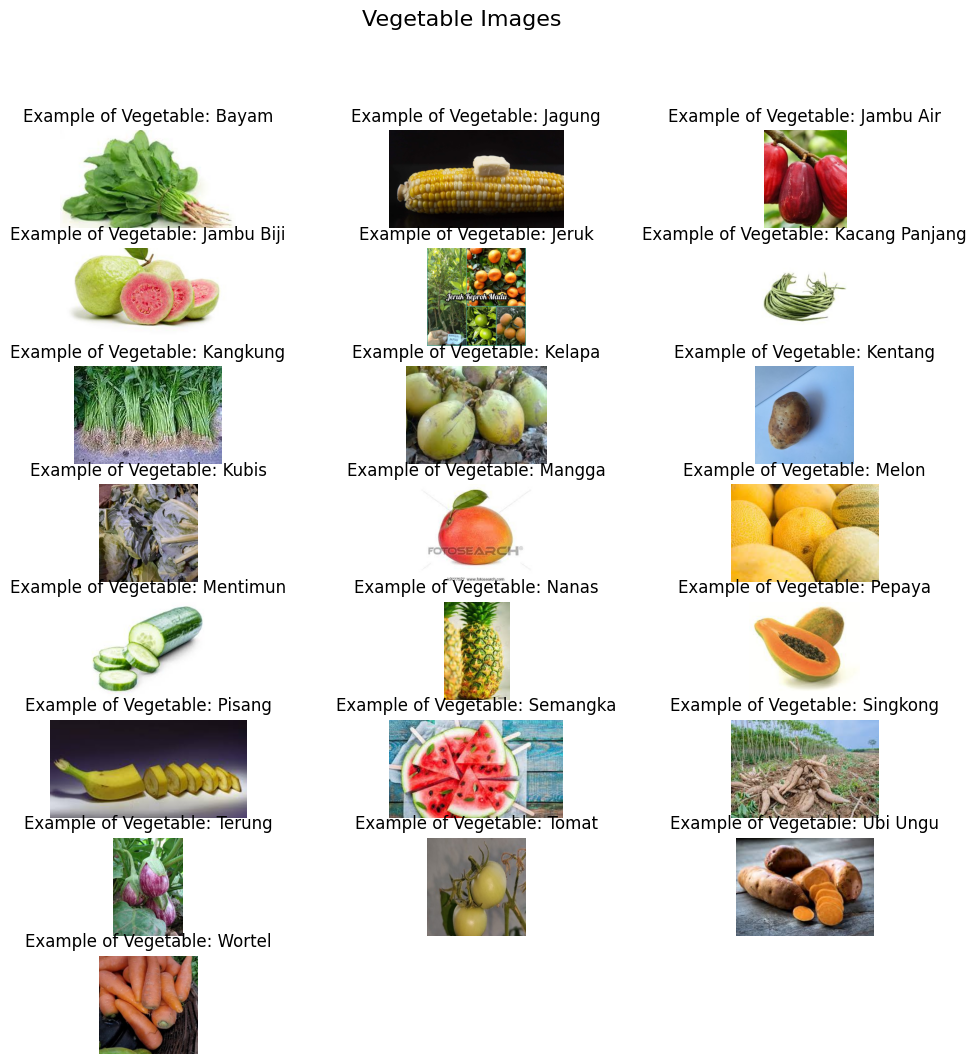

In [4]:
NUM_CLASSES = len(os.listdir(TRAIN_DIR))
plot_data(TRAIN_DIR, 'Vegetable', NUM_CLASSES, 3)

In [5]:
def get_image_array(classname):
  dir_path = f'{TRAIN_DIR}/{classname}'
  img = tf.keras.preprocessing.image.load_img(dir_path + '/' + os.listdir(dir_path)[0])
  array = tf.keras.preprocessing.image.img_to_array(img)
  return array

In [6]:
sample_array = get_image_array('Pisang')
print(f"Each image has size: {sample_array.shape}")
sample_array[0,:5]

Each image has size: (159, 318, 3)


array([[29., 22., 30.],
       [29., 22., 30.],
       [29., 22., 30.],
       [29., 22., 30.],
       [29., 22., 30.]], dtype=float32)

In [7]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=10,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    vertical_flip=True,
                    fill_mode='reflect')

valid_datagen = ImageDataGenerator(
                    rescale=1./255)

test_datagen = ImageDataGenerator(
                    rescale=1./255)

In [8]:
def load_generator(datagen, PATH, IMAGE_SIZE, BATCH_SIZE, LABEL_MODE):
  generator = datagen.flow_from_directory(
    PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=LABEL_MODE,
    shuffle=False if PATH == TEST_DIR else True,
    seed=42
  )
  return generator

In [9]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
LABEL_MODE = 'categorical'
BUFFER_SIZE = tf.data.AUTOTUNE

train_generator = load_generator(train_datagen, TRAIN_DIR, IMAGE_SIZE, BATCH_SIZE, LABEL_MODE)
validation_generator = load_generator(valid_datagen, VAL_DIR, IMAGE_SIZE, BATCH_SIZE, LABEL_MODE)
test_generator = load_generator(test_datagen, TEST_DIR, IMAGE_SIZE, BATCH_SIZE, LABEL_MODE)

Found 8448 images belonging to 22 classes.
Found 2112 images belonging to 22 classes.
Found 2640 images belonging to 22 classes.


In [10]:
pretrained_model = DenseNet121(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

pretrained_model.trainable = False

In [11]:
checkpoint_path = "D:/Kuliah/Skripsi/DenseNet121/model_checkpoint_600.weights.h5"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [12]:
def build_model(base_model):
  model = Sequential(
    [
        base_model,
        Flatten(),
        Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        Dropout(0.2),
        Dense(NUM_CLASSES, activation='softmax')
    ]
  )
  return model

In [13]:
model = build_model(pretrained_model)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 22)             │         2,838 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,463,510 (51.36 MB)

 Trainable params: 6,425,750 (24.51 MB)

 Non-trainable params: 7,037,760 (26.85 MB)

In [14]:
LEARNING_RATE = 0.001
EPOCHS = 50
model.compile(
    loss=CategoricalCrossentropy(),
    optimizer=Adam(learning_rate=LEARNING_RATE),
    metrics=['accuracy']
)

In [15]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[checkpoint_callback]
)

c:\Users\ALFIAN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1145s 4s/step - accuracy: 0.6911 - loss: 1.1345 - val_accuracy: 0.9290 - val_loss: 0.2337
Epoch 2/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 937s 4s/step - accuracy: 0.8999 - loss: 0.3583 - val_accuracy: 0.9361 - val_loss: 0.2144
Epoch 3/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 917s 3s/step - accuracy: 0.9202 - loss: 0.2717 - val_accuracy: 0.9351 - val_loss: 0.1926
Epoch 4/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 919s 3s/step - accuracy: 0.9283 - loss: 0.2387 - val_accuracy: 0.9451 - val_loss: 0.1632
Epoch 5/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 903s 3s/step - accuracy: 0.9321 - loss: 0.2174 - val_accuracy: 0.9437 - val_loss: 0.1662
Epoch 6/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 890s 3s/step - accuracy: 0.9351 - loss: 0.1982 - val_accuracy: 0.9479 - val_loss: 0.1720
Epoch 7/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 877s 3s/step - accuracy: 0.9347 - loss: 0.2041 - val_accuracy: 0.9522 - val_loss: 0.1423
Epoch 8/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 887s 3s/step - accuracy: 0.9411 - loss: 0.1832 - val_acc

In [16]:
def plot_metrics(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  fig, ax = plt.subplots(1, 2, figsize=(12, 6))
  fig.suptitle('Training and Validation Metrics DenseNet121')

  for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
      ax[i].plot(epochs, data[0], 'orange', label="Training " + label)
      ax[i].plot(epochs, data[1], 'steelblue', label="Validation " + label)
      ax[i].legend()
      ax[i].set_xlabel('epochs')

  plt.show()

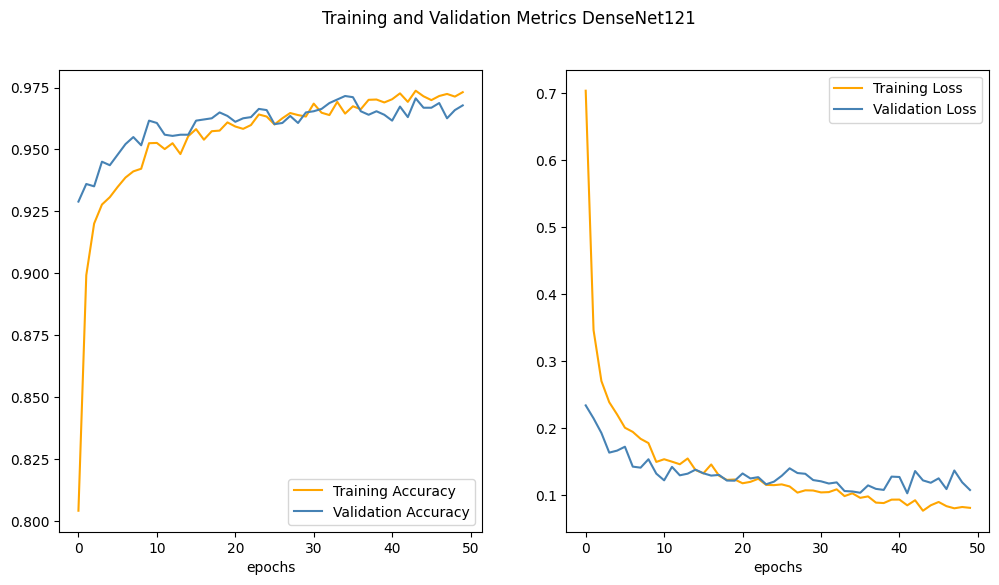

In [17]:
plot_metrics(history)

In [18]:
num_test_files = sum([len(files) for r, d, files in os.walk(TEST_DIR)])
num_test_steps = num_test_files // BATCH_SIZE

acc = model.evaluate(test_generator, batch_size=BATCH_SIZE, verbose=1, steps=num_test_steps)[1] * 100
print(f"Accuracy on the test set is {acc:.2f} %")

82/82 ━━━━━━━━━━━━━━━━━━━━ 242s 3s/step - accuracy: 0.9630 - loss: 0.1466
Accuracy on the test set is 96.95 %


83/83 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step


C:\Users\ALFIAN\AppData\Local\Temp\ipykernel_13860\1543736279.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = colormap.get_cmap('tab10', len(filtered_labels)).colors


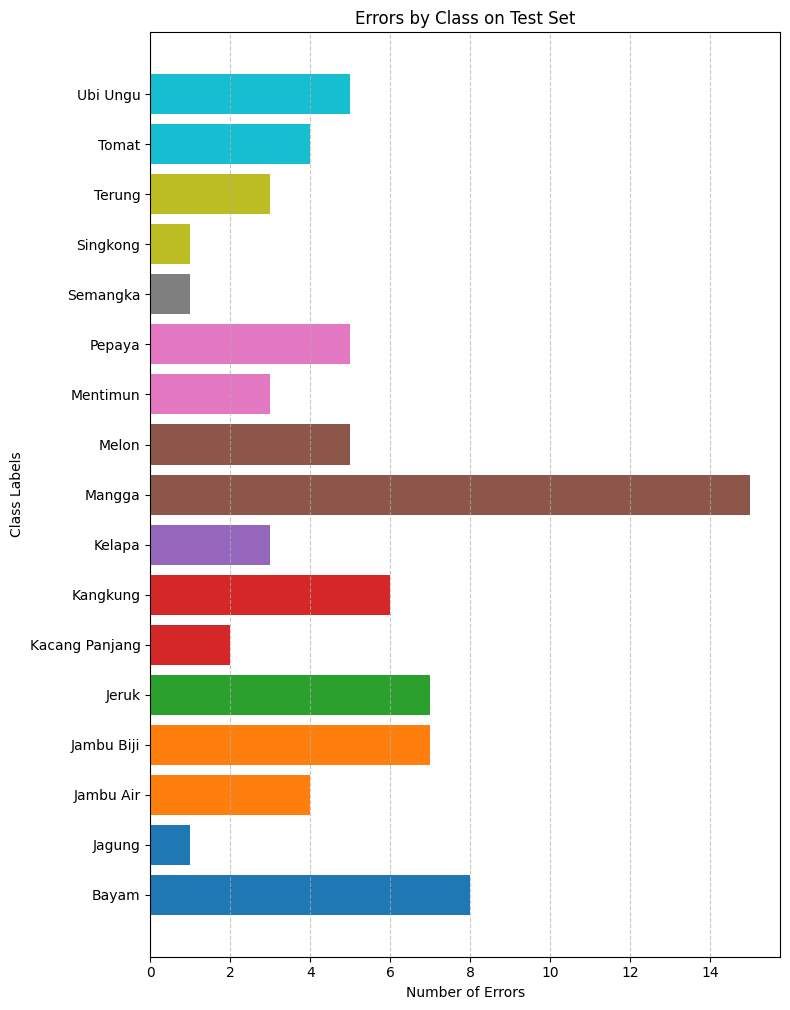

In [19]:
predictions = model.predict(test_generator, verbose=1)

y_true = test_generator.classes
y_pred = np.argmax(predictions, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)
errors_per_class = conf_matrix.sum(axis=1) - np.diag(conf_matrix)

class_labels = list(test_generator.class_indices.keys())

filtered_labels = [label for label, errors in zip(class_labels, errors_per_class) if errors > 0]
filtered_errors = [errors for errors in errors_per_class if errors > 0]

colors = colormap.get_cmap('tab10', len(filtered_labels)).colors

plt.figure(figsize=(8, len(filtered_labels) * 0.6))
plt.barh(filtered_labels, filtered_errors, color=colors)
plt.title('Errors by Class on Test Set', fontsize=12)
plt.xlabel('Number of Errors', fontsize=10)
plt.ylabel('Class Labels', fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

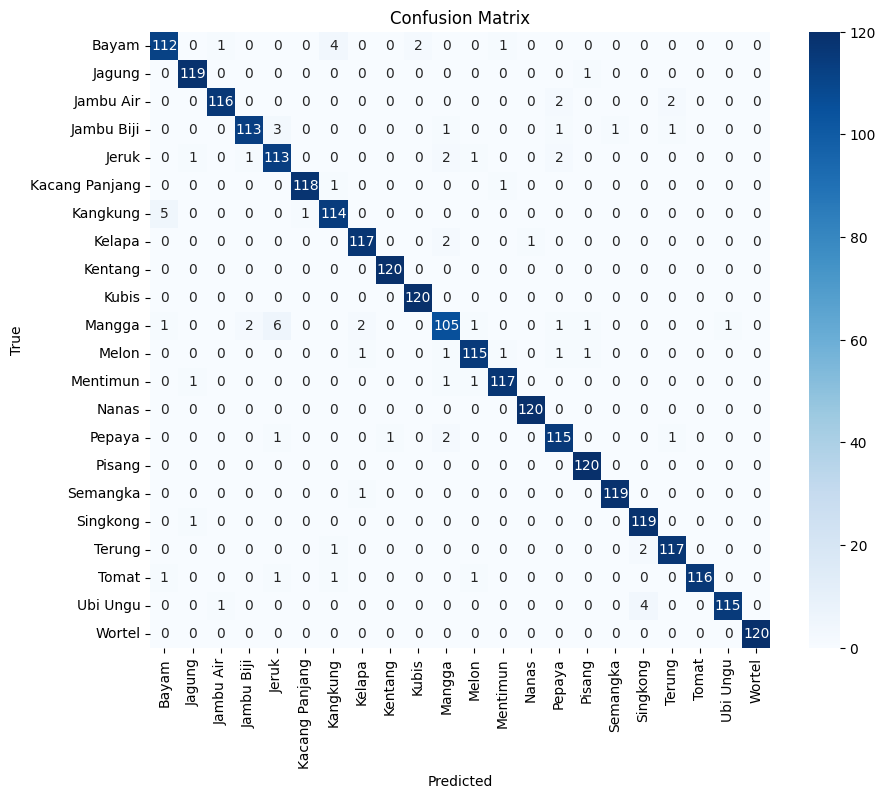

In [20]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [21]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

Classification Report:
                precision    recall  f1-score   support

         Bayam       0.94      0.93      0.94       120
        Jagung       0.98      0.99      0.98       120
     Jambu Air       0.98      0.97      0.97       120
    Jambu Biji       0.97      0.94      0.96       120
         Jeruk       0.91      0.94      0.93       120
Kacang Panjang       0.99      0.98      0.99       120
      Kangkung       0.94      0.95      0.95       120
        Kelapa       0.97      0.97      0.97       120
       Kentang       0.99      1.00      1.00       120
         Kubis       0.98      1.00      0.99       120
        Mangga       0.92      0.88      0.90       120
         Melon       0.97      0.96      0.96       120
      Mentimun       0.97      0.97      0.97       120
         Nanas       0.99      1.00      1.00       120
        Pepaya       0.94      0.96      0.95       120
        Pisang       0.98      1.00      0.99       120
      Semangka       0.9

In [22]:
def process_image(image_path, target_size=(224, 224)):

    image = tf.keras.utils.load_img(image_path, target_size=target_size)
    image_array = tf.keras.utils.img_to_array(image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)
    return image_array

def predict_image(model, file_content, class_labels):

    image = tf.keras.utils.load_img(BytesIO(file_content), target_size=(224, 224))
    processed_image = tf.keras.utils.img_to_array(image) / 255.0
    processed_image = np.expand_dims(processed_image, axis=0)

    prediction = model.predict(processed_image)[0]
    predicted_class = np.argmax(prediction)

    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Predicted: {class_labels[predicted_class]} (Confidence: {prediction[predicted_class]*100:.2f}%)")
    plt.show()

    print("Prediction Probabilities:")
    for i, prob in enumerate(prediction):
        print(f"{class_labels[i]}: {prob*100:.2f}%")

uploader = widgets.FileUpload(accept="image/*", multiple=False)
display(uploader)

output = widgets.Output()
display(output)

def on_file_upload(change):
    with output:
        output.clear_output()
        for filename, file_info in uploader.value.items():
            file_content = file_info["content"]
            print(f"Processing file: {filename}")
            #Predict Image
            predict_image(model_to_use, file_content, class_labels)

class_labels = list(test_generator.class_indices.keys())

model_to_use = model

uploader.observe(on_file_upload, names="value")

FileUpload(value=(), accept='image/*', description='Upload')

Output()

In [23]:
model.save("D:/Kuliah/Skripsi/DenseNet121/model_densenet_600.h5")